In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.pyplot import rc_context
from tqdm import tqdm
from scipy.optimize import curve_fit

#import scvi
import pickle
from adjustText import adjust_text
import matplotlib.patches as patches

In [2]:
#three primary datasets, human, hippocampus, and TS
#separate hippo analysis because processed with different reference

# sc.read_h5ad('/home/ubuntu/s3_mount/Data/HUMAN_CELLS_MS0203.h5ad')
# sc.read_h5ad('/home/ubuntu/s3_mount/Data/human_hippo/human_hippo_harmonized.h5ad')
# sc.read_h5ad('/home/ubuntu/s3_mount/Data/tabula_sapiens/TS_harmonized.h5ad')



In [3]:
#import markers and convert to human format


with open('../data/gene_lists/human_markers.txt') as f:
    markers = list(f)
markers = [x for x in markers if not x.startswith('#') and ':' in x]
markers = dict(map(lambda x: x.strip().split(':'), markers)) #dict marker:role

markers = {k.upper(): v for k, v in markers.items()}


# HUMAN and hippo separate because different references/genes

In [8]:
adata = sc.concat((sc.read_h5ad('/home/jrlab/Downloads//HUMAN_CELLS_MS0203.h5ad')
                   ,sc.read_h5ad('/home/jrlab/Downloads/TS_harmonized.h5ad')))

hippo = sc.read_h5ad('/home/jrlab/Downloads/human_hippo_harmonized.h5ad')

In [13]:
#annotate data
with open('../data/annotations/human/liver_index_dictionary.pickle', 'rb') as handle:
     fin_liver_d = pickle.load(handle)

with open('../data/annotations/human/skin_index_dictionary.pickle', 'rb') as handle:
     fin_skin_d = pickle.load(handle)
        
with open('../data/annotations/human/lung_index_dictionary.pickle', 'rb') as handle:
     fin_lung_d = pickle.load(handle)
   
with open('../data/annotations/human/hcl_index_dictionary.pickle', 'rb') as handle:
     fin_hcl_d = pickle.load(handle)
        
with open('../data/annotations/human/hippo_index_dictionary.pickle', 'rb') as handle:
     fin_hippo_d = pickle.load(handle)

big_d = fin_liver_d | fin_skin_d | fin_lung_d | fin_hcl_d | fin_hippo_d


adata.obs['temp_id'] = adata.obs.index

def cell_type_mapper(x):
    cell, cell_type = x
    if cell_type == 'not typed':
        try:
            return big_d[cell]
        except:
            return 'drop'
    else:
        return cell_type
    
adata.obs.cell_type = adata.obs[['temp_id', 'cell_type']].apply(cell_type_mapper, axis = 1)
adata = adata[adata.obs.cell_type != 'drop']
adata.obs['is_na'] = adata.obs.isnull().sum(axis = 1) #cell_type_mapper returns NA if not in dict
adata = adata[adata.obs['is_na'] == 0]
adata.obs = adata.obs.drop(columns = ['temp_id', 'is_na'])


relabel_d = pd.read_csv('../data/annotations/human/harmonized_all_cell_counts.csv').dropna()
relabel_d = dict(zip(relabel_d.cell_type, relabel_d.new_label))

def a_mapper(x):
    try:
        return relabel_d[x].strip().lower()
    except:
        return x.strip().lower()
    
adata.obs['cell_type_2'] = adata.obs.cell_type.map(a_mapper)


adata.obs.tissue = adata.obs.tissue.map(lambda x: x.lower())
adata.obs.tissue = adata.obs.tissue.map(lambda x: x.replace('_', ' ').replace('-', ' '))
adata.obs.tissue = adata.obs.tissue.replace('fat', 'adipose')
adata.obs.tissue = adata.obs.tissue.replace('peripheral blood', 'blood')

/tmp/ipykernel_1537367/3091437583.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['is_na'] = adata.obs.isnull().sum(axis = 1) #cell_type_mapper returns NA if not in dict


In [14]:
hippo = hippo[~hippo.obs.cell_type.isna()]
hippo.obs['cell_type_2'] = hippo.obs.cell_type #just to make similar to adata

/tmp/ipykernel_1537367/351556575.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hippo.obs['cell_type_2'] = hippo.obs.cell_type #just to make similar to adata


In [15]:
hippo.obs.head() 

,tissue,cell_type,age,sex,donor,sample,disease,tech,study,ref,cell_type_2
AAACATCGAAGACGGACATCAAGT-2,hippocampus,oligodendrocyte,0.6,M,2,2,healthy,SPLiT-seq,GSE185553,10.1038/s41586-022-04912-w,oligodendrocyte
AAACATCGAATCCGTCCATCAAGT-2,hippocampus,oligodendrocyte,0.6,M,2,2,healthy,SPLiT-seq,GSE185553,10.1038/s41586-022-04912-w,oligodendrocyte
AAACATCGAATCCGTCCGCATACA-2,hippocampus,microglia,0.6,M,2,2,healthy,SPLiT-seq,GSE185553,10.1038/s41586-022-04912-w,microglia
AAACATCGACACGACCCGCATACA-2,hippocampus,excitatory neuron,0.6,M,2,2,healthy,SPLiT-seq,GSE185553,10.1038/s41586-022-04912-w,excitatory neuron
AAACATCGACATTGGCCATCAAGT-2,hippocampus,oligodendrocyte,0.6,M,2,2,healthy,SPLiT-seq,GSE185553,10.1038/s41586-022-04912-w,oligodendrocyte


In [16]:
len([x for x in list(markers) if x not in hippo.var_names]) 
#many markers not in dataset, were they not expressed in any cells and filtered?

48

In [17]:
adata.obs.head()

,tissue,cell_type,age,sex,donor,sample,disease,tech,study,ref,cell_type_2
AAACCTGAGCAGCCTC-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,endothelial cell
AAACCTGTCTAAGCCA-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,endothelial cell
AAACGGGAGTAGGCCA-1_L1,liver,macrophage,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,macrophage
AAACGGGAGTTAGCGG-1_L1,liver,monocyte,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,monocyte
AAACGGGGTCGGGTCT-1_L1,liver,monocyte,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,monocyte


In [18]:
[x for x in list(markers) if x not in adata.var_names]

['TGFB1']

In [19]:
#del markers['TGFB1'] #idk why this isnt in there !!!dont delete this

In [20]:
'TGFB1' in hippo.var_names

True

### Find cell_tissues that have enough cells over time to test, adata

In [21]:
np.sort(adata.obs.age.unique())

array([18. , 21. , 22. , 23. , 24. , 25. , 26. , 29. , 30. , 32. , 33. ,
       34. , 36. , 37. , 38. , 39. , 40. , 41. , 42. , 42.5, 44. , 45. ,
       46. , 47. , 47.5, 48. , 49. , 51. , 52. , 52.5, 53. , 55. , 56. ,
       57. , 57.5, 58. , 59. , 60. , 61. , 62. , 62.5, 63. , 64. , 65. ,
       66. , 67. , 67.5, 68. , 69. , 71. , 72. , 72.5, 74. ])

In [13]:
# #bins age in 10 year bins
# def age_bin(x):
#     for y in range(18,74,10):
#         if y > x:
#             return y - 10
#     return y

In [22]:
#bins age in 10 year bins
def age_bin(x):
    for y in range(18,92,10):
        if y > x:
            return y - 10
    return y

In [23]:
adata.obs['bin_age'] = adata.obs.age.map(age_bin)

In [24]:
adata.obs.head()

,tissue,cell_type,age,sex,donor,sample,disease,tech,study,ref,cell_type_2,bin_age
AAACCTGAGCAGCCTC-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,endothelial cell,38
AAACCTGTCTAAGCCA-1_L1,liver,endothelial cell of hepatic sinusoid,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,endothelial cell,38
AAACGGGAGTAGGCCA-1_L1,liver,macrophage,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,macrophage,38
AAACGGGAGTTAGCGG-1_L1,liver,monocyte,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,monocyte,38
AAACGGGGTCGGGTCT-1_L1,liver,monocyte,44.0,M,liver_1,SRR7276474,healthy,10x,liver,10.1038/s41467-018-06318-7,monocyte,38


In [25]:
# df = adata.obs.groupby(['tissue', 'cell_type_2', 'bin_age']).count().reset_index()
# df = df.pivot(values='cell_type', index = ['tissue', 'cell_type_2'], columns = 'bin_age').reset_index()
# df = df.fillna(0)
# df

In [26]:
'''
criteria:
must have at least 3 bins with > 100 cells each OR a bin in 18-28 and 58-68
must have one bin >=age48 with > 100 cells
'''
def remove_limited_data(x):
    #[18,28,38,48,58,68]
    #[0 ,1 ,2 ,3 ,4 ,5 ]
    
    if len(x[x > 100]) < 3 or (len(x[0:2][x[0:2] > 100]) == 0 and len(x[4:][x[4:] > 100]) == 0):
        return False
    if len(x[3:][x[3:] > 100]) < 1:
        return False
    
    return True
    


In [29]:
'''
v2: in individual study, to reduce effects from differences in gene coverage

'''


df = adata.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study']).count().reset_index()
df = df.pivot(values='cell_type', index = ['tissue', 'cell_type_2', 'study'], columns = 'bin_age').reset_index()
#df = df.fillna(0)
df
    


/tmp/ipykernel_1537367/1840406713.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study']).count().reset_index()


bin_age,tissue,cell_type_2,study,18,28,38,48,58,68
0,adipose,acinar cell,TS,0,0,0,0,0,0
1,adipose,acinar cell,hcl,0,0,0,0,0,0
2,adipose,acinar cell,heart,0,0,0,0,0,0
3,adipose,acinar cell,liver,0,0,0,0,0,0
4,adipose,acinar cell,lung,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
23971,vasculature,unknown,hcl,0,0,0,0,0,0
23972,vasculature,unknown,heart,0,0,0,0,0,0
23973,vasculature,unknown,liver,0,0,0,0,0,0
23974,vasculature,unknown,lung,0,0,0,0,0,0


In [35]:
df = df[df[[18,28,38,48,58,68]].apply(remove_limited_data, axis = 1)]
df = df.reset_index(drop = True)
len(df)

47

In [36]:
df.groupby(['tissue', 'study']).sum().reset_index()
#check to make sure only one study per tissue, or will have to choose study with better representation

/tmp/ipykernel_1537367/3485146867.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['tissue', 'study']).sum().reset_index()


bin_age,tissue,study,cell_type_2,18,28,38,48,58,68
0,blood,TS,erythrocytememory b cellmonocytenaive b cellne...,0,4892,0,1934,24455,16961
1,blood,hcl,0,0,0,0,0,0,0
2,blood,heart,0,0,0,0,0,0,0
3,blood,liver,0,0,0,0,0,0,0
4,blood,lung,0,0,0,0,0,0,0
5,blood,skin,0,0,0,0,0,0,0
6,bone marrow,TS,t cell,116,0,1002,0,2054,0
7,bone marrow,hcl,0,0,0,0,0,0,0
8,bone marrow,heart,0,0,0,0,0,0,0
9,bone marrow,liver,0,0,0,0,0,0,0


## cells with enough to test from hippo

In [37]:
np.sort(hippo.obs.age.unique())

array([ 0.6,  1.2,  2.1,  3.2,  4. ,  4.3,  6.7, 13. , 14.7, 15.3, 18.5,
       40. , 50. , 50.2, 59. , 60. , 73. , 74. , 75. , 77. , 78. , 79. ,
       80. , 83. , 85. , 86. , 88. , 89. , 90. , 92. ])

In [38]:
hippo.obs['bin_age'] = hippo.obs.age.map(age_bin)
hippo.obs['study'] = 'hippo'

In [39]:
dfh = hippo.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study']).count().reset_index()
dfh = dfh.pivot(values='cell_type', index = ['tissue', 'cell_type_2', 'study'], columns = 'bin_age').reset_index()
dfh[28] = 0
dfh = dfh[['tissue','cell_type_2', 'study', 8,18,28,38,48,58,68,78,88]]
#dfh = dfh.fillna(0)
dfh

/tmp/ipykernel_1537367/2563871332.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfh = hippo.obs.groupby(['tissue', 'cell_type_2', 'bin_age', 'study']).count().reset_index()


bin_age,tissue,cell_type_2,study,8,18,28,38,48,58,68,78,88
0,hippocampus,GABA interneuron,hippo,5803,137,0,967,794,1242,2347,3096,2217
1,hippocampus,astrocyte,hippo,5284,510,0,2129,802,2060,3080,3347,3491
2,hippocampus,cajal-retzius cell,hippo,39,2,0,22,0,21,11,15,10
3,hippocampus,choroid plexus cells,hippo,631,59,0,7,3,356,528,517,218
4,hippocampus,dentate granule cell,hippo,10935,186,0,10649,879,1545,6994,6512,6179
5,hippocampus,endothelial cells,hippo,485,27,0,282,51,119,443,318,277
6,hippocampus,ependymal cell,hippo,345,18,0,218,53,126,424,265,342
7,hippocampus,excitatory neuron,hippo,22361,189,0,1675,6877,3606,7998,8071,8087
8,hippocampus,microglia,hippo,1323,533,0,447,473,640,1105,1799,1009
9,hippocampus,oligodendrocyte,hippo,6878,2875,0,2691,5607,2577,6694,12747,6702


In [40]:
hippo_not_enough = ['cajal-retzius cell']
dfh = dfh[~dfh.cell_type_2.isin(hippo_not_enough)].reset_index(drop = True)
dfh['hippo'] = 'yes'
dfh

bin_age,tissue,cell_type_2,study,8,18,28,38,48,58,68,78,88,hippo
0,hippocampus,GABA interneuron,hippo,5803,137,0,967,794,1242,2347,3096,2217,yes
1,hippocampus,astrocyte,hippo,5284,510,0,2129,802,2060,3080,3347,3491,yes
2,hippocampus,choroid plexus cells,hippo,631,59,0,7,3,356,528,517,218,yes
3,hippocampus,dentate granule cell,hippo,10935,186,0,10649,879,1545,6994,6512,6179,yes
4,hippocampus,endothelial cells,hippo,485,27,0,282,51,119,443,318,277,yes
5,hippocampus,ependymal cell,hippo,345,18,0,218,53,126,424,265,342,yes
6,hippocampus,excitatory neuron,hippo,22361,189,0,1675,6877,3606,7998,8071,8087,yes
7,hippocampus,microglia,hippo,1323,533,0,447,473,640,1105,1799,1009,yes
8,hippocampus,oligodendrocyte,hippo,6878,2875,0,2691,5607,2577,6694,12747,6702,yes
9,hippocampus,oligodendrocyte precursor cell,hippo,3823,253,0,1092,655,1489,1780,2169,2318,yes


In [41]:
df['hippo'] = 'no'
df[8] = 0
df[78] = 0
df[88] = 0
df = df[dfh.columns]
df = pd.concat((df, dfh)).reset_index(drop = True)

In [42]:
df

bin_age,tissue,cell_type_2,study,8,18,28,38,48,58,68,78,88,hippo
0,blood,erythrocyte,TS,0,0,824,0,1,2060,7599,0,0,no
1,blood,memory b cell,TS,0,0,273,0,47,267,267,0,0,no
2,blood,monocyte,TS,0,0,2056,0,225,10847,3063,0,0,no
3,blood,naive b cell,TS,0,0,766,0,26,718,729,0,0,no
4,blood,neutrophil,TS,0,0,0,0,1567,5858,1031,0,0,no
5,blood,nk cell,TS,0,0,514,0,10,715,1709,0,0,no
6,blood,t cell,TS,0,0,459,0,58,3990,2563,0,0,no
7,bone marrow,t cell,TS,0,116,0,1002,0,2054,0,0,0,no
8,heart,adipocyte,heart,0,0,0,791,1617,1155,236,0,0,no
9,heart,cardiomyocyte,heart,0,0,0,28434,63541,46850,9947,0,0,no


## Cell_tissue Dyanmics

In [3]:
cell_type_2_annotations = pd.read_csv('../data/annotations/human/cell_classes.csv')

class_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['class']))
compartment_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['compartment']))

In [4]:
df.head()
#make sure all tissue_cell types correspond to only one study

NameError: name 'df' is not defined

In [45]:
temp = []
for tissue, cell , study in tqdm(list(zip(df.tissue, df.cell_type_2, df.study))):
    for age in [8,18,28,38,48,58,68,78,88]:
        if tissue != 'hippocampus':
            sdata = adata[(adata.obs.tissue == tissue) & (adata.obs.cell_type_2 == cell) &\
                          (adata.obs.bin_age.astype('int') == age) &\
                          (adata.obs.study == study)].X.toarray()
            svars = adata.var_names
        else:
            sdata = hippo[(hippo.obs.tissue == tissue) & (hippo.obs.cell_type_2 == cell) &\
                          (hippo.obs.bin_age.astype('int') == age)].X.toarray()
            svars = hippo.var_names
        
        for gene in list(markers):
            if gene in svars:
                temp2 = [tissue, cell, age, gene]
                if len(sdata) > 100:
                    i = np.where(svars == gene)[0][0]
                    a = sdata[:,i]
                    v = a[a > 0].shape[0] / a.shape[0]
                    
                    
                    if v == 0: #is this the fix i was talking about in the first line?
                        v = 1/len(a)
                    
                    
                else:
                    v = -1
                temp2 += [v]
                temp.append(temp2)

100%|███████████████████████████████████████████| 57/57 [02:58<00:00,  3.12s/it]


In [46]:
tc_df = pd.DataFrame(temp, columns = ['tissue', 'cell_type_2', 'age_bin', 'gene', 'value'])

tc_df = tc_df.pivot(values = 'value', index = ['tissue','cell_type_2', 'gene'], columns = 'age_bin').reset_index()

tc_df['Class'] = tc_df.cell_type_2.map(class_d)
tc_df['compartment'] = tc_df.cell_type_2.map(compartment_d)

tc_df

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,78,88,Class,compartment
0,blood,erythrocyte,ADAM17,-1.0,-1.0,0.024272,-1.000000,-1.0,0.017961,0.011975,-1.0,-1.0,immune,immune
1,blood,erythrocyte,ANG,-1.0,-1.0,0.002427,-1.000000,-1.0,0.001942,0.003158,-1.0,-1.0,immune,immune
2,blood,erythrocyte,AREG,-1.0,-1.0,0.008495,-1.000000,-1.0,0.016990,0.058297,-1.0,-1.0,immune,immune
3,blood,erythrocyte,BCL2,-1.0,-1.0,0.019417,-1.000000,-1.0,0.002913,0.014739,-1.0,-1.0,immune,immune
4,blood,erythrocyte,BCL2L1,-1.0,-1.0,0.867718,-1.000000,-1.0,0.843204,0.847612,-1.0,-1.0,immune,immune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5624,tongue,basal cell,TIMP2,-1.0,-1.0,-1.000000,0.006098,-1.0,0.053806,0.082726,-1.0,-1.0,progenitor,epithelial
5625,tongue,basal cell,TP53,-1.0,-1.0,-1.000000,0.274390,-1.0,0.559055,0.354062,-1.0,-1.0,progenitor,epithelial
5626,tongue,basal cell,VEGFA,-1.0,-1.0,-1.000000,0.067073,-1.0,0.582677,0.505135,-1.0,-1.0,progenitor,epithelial
5627,tongue,basal cell,VEGFB,-1.0,-1.0,-1.000000,0.030488,-1.0,0.464567,0.311485,-1.0,-1.0,progenitor,epithelial


In [47]:
def gene_stats(x):
    ages = np.array([8,18,28,38,48,58,68,78,88])
    mask = x > -1
    
    ages = ages[mask]
    x = x[mask]
    
    lin = stats.linregress(ages, x)
    
    if 18 in ages or 28 in ages or 8 in ages:
        starting = x.iloc[0]
    else:
        starting = lin.slope*18 + lin.intercept
        
    if starting < 0:
        starting = 0
        
    ending = x.iloc[-1]

    return lin.slope, x.iloc[0], x.max(), lin.pvalue, len(x), starting, ending
    
    

In [48]:
tc_df['slope'], tc_df['starting'], tc_df['Max'], tc_df['lin_p'], tc_df['N'], tc_df['starting'], tc_df['ending'] =\
zip(*tc_df[[8,18,28,38,48,58,68,78,88]].apply(gene_stats, axis = 1))


tc_df['gain'] = tc_df.ending - tc_df.starting

In [49]:
tc_df

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
0,blood,erythrocyte,ADAM17,-1.0,-1.0,0.024272,-1.000000,-1.0,0.017961,0.011975,...,-1.0,immune,immune,-0.000285,0.024272,0.024272,0.169205,3,0.011975,-0.012297
1,blood,erythrocyte,ANG,-1.0,-1.0,0.002427,-1.000000,-1.0,0.001942,0.003158,...,-1.0,immune,immune,0.000010,0.002427,0.003158,0.771684,3,0.003158,0.000731
2,blood,erythrocyte,AREG,-1.0,-1.0,0.008495,-1.000000,-1.0,0.016990,0.058297,...,-1.0,immune,immune,0.001023,0.008495,0.058297,0.410312,3,0.058297,0.049802
3,blood,erythrocyte,BCL2,-1.0,-1.0,0.019417,-1.000000,-1.0,0.002913,0.014739,...,-1.0,immune,immune,-0.000217,0.019417,0.019417,0.643726,3,0.014739,-0.004679
4,blood,erythrocyte,BCL2L1,-1.0,-1.0,0.867718,-1.000000,-1.0,0.843204,0.847612,...,-1.0,immune,immune,-0.000575,0.867718,0.867718,0.262295,3,0.847612,-0.020107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5624,tongue,basal cell,TIMP2,-1.0,-1.0,-1.000000,0.006098,-1.0,0.053806,0.082726,...,-1.0,progenitor,epithelial,0.002530,0.000000,0.082726,0.031517,3,0.082726,0.082726
5625,tongue,basal cell,TP53,-1.0,-1.0,-1.000000,0.274390,-1.0,0.559055,0.354062,...,-1.0,progenitor,epithelial,0.004310,0.237815,0.559055,0.704086,3,0.354062,0.116246
5626,tongue,basal cell,VEGFA,-1.0,-1.0,-1.000000,0.067073,-1.0,0.582677,0.505135,...,-1.0,progenitor,epithelial,0.016199,0.000000,0.582677,0.301366,3,0.505135,0.505135
5627,tongue,basal cell,VEGFB,-1.0,-1.0,-1.000000,0.030488,-1.0,0.464567,0.311485,...,-1.0,progenitor,epithelial,0.011129,0.000000,0.464567,0.438346,3,0.311485,0.311485


In [50]:
tc_df_filt = tc_df[(tc_df.slope > 0) &\
      (tc_df.Max < 0.25) &\
      (tc_df.starting < .05) &\
      (tc_df.gain > 0.01)]

tc_df_filt

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
2,blood,erythrocyte,AREG,-1.0,-1.0,0.008495,-1.000000,-1.0,0.016990,0.058297,...,-1.0,immune,immune,0.001023,0.008495,0.058297,0.410312,3,0.058297,0.049802
17,blood,erythrocyte,CCL3,-1.0,-1.0,0.009709,-1.000000,-1.0,0.002427,0.033162,...,-1.0,immune,immune,0.000395,0.009709,0.033162,0.657823,3,0.033162,0.023454
18,blood,erythrocyte,CCL4,-1.0,-1.0,0.008495,-1.000000,-1.0,0.004854,0.037505,...,-1.0,immune,immune,0.000530,0.008495,0.037505,0.577127,3,0.037505,0.029010
38,blood,erythrocyte,CXCL5,-1.0,-1.0,0.002427,-1.000000,-1.0,0.002913,0.018950,...,-1.0,immune,immune,0.000321,0.002427,0.018950,0.495810,3,0.018950,0.016523
39,blood,erythrocyte,CXCL8,-1.0,-1.0,0.006068,-1.000000,-1.0,0.033010,0.043822,...,-1.0,immune,immune,0.000933,0.006068,0.043822,0.024952,3,0.043822,0.037754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,tongue,basal cell,MMP9,-1.0,-1.0,-1.000000,0.006098,-1.0,0.001312,0.012512,...,-1.0,progenitor,epithelial,0.000149,0.001174,0.012512,0.734371,3,0.012512,0.011337
5615,tongue,basal cell,PLAT,-1.0,-1.0,-1.000000,0.030488,-1.0,0.024934,0.059010,...,-1.0,progenitor,epithelial,0.000775,0.009718,0.059010,0.551434,3,0.059010,0.049292
5619,tongue,basal cell,SERPINE1,-1.0,-1.0,-1.000000,0.042683,-1.0,0.035433,0.057890,...,-1.0,progenitor,epithelial,0.000383,0.031303,0.057890,0.659243,3,0.057890,0.026587
5620,tongue,basal cell,TFEB,-1.0,-1.0,-1.000000,0.024390,-1.0,0.206037,0.144911,...,-1.0,progenitor,epithelial,0.004741,0.000000,0.206037,0.426843,3,0.144911,0.144911


In [51]:
tc_df_filt[tc_df_filt.tissue == 'hippocampus']

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
2046,hippocampus,choroid plexus cells,ADAM17,0.042789,-1.000000,-1.0,-1.000000,-1.000000,0.044944,0.070076,...,0.068807,epithelial,epithelial,0.000341,0.042789,0.070076,0.102096,5,0.068807,0.026018
2055,hippocampus,choroid plexus cells,CDKN1B,0.023772,-1.000000,-1.0,-1.000000,-1.000000,0.039326,0.034091,...,0.050459,epithelial,epithelial,0.000185,0.023772,0.050459,0.430373,5,0.050459,0.026687
2056,hippocampus,choroid plexus cells,CDKN2A,0.007924,-1.000000,-1.0,-1.000000,-1.000000,0.011236,0.017045,...,0.027523,epithelial,epithelial,0.000292,0.007924,0.036750,0.133024,5,0.027523,0.019599
2057,hippocampus,choroid plexus cells,CDKN2B,0.003170,-1.000000,-1.0,-1.000000,-1.000000,0.002809,0.026515,...,0.018349,epithelial,epithelial,0.000197,0.003170,0.026515,0.280443,5,0.018349,0.015179
2062,hippocampus,choroid plexus cells,CXCL14,0.012678,-1.000000,-1.0,-1.000000,-1.000000,0.056180,0.020833,...,0.036697,epithelial,epithelial,0.000226,0.012678,0.056180,0.485338,5,0.036697,0.024019
2067,hippocampus,choroid plexus cells,EPHA2,0.003170,-1.000000,-1.0,-1.000000,-1.000000,0.011236,0.026515,...,0.018349,epithelial,epithelial,0.000220,0.003170,0.026515,0.115341,5,0.018349,0.015179
2074,hippocampus,choroid plexus cells,IGFBP2,0.044374,-1.000000,-1.0,-1.000000,-1.000000,0.123596,0.062500,...,0.059633,epithelial,epithelial,0.000188,0.044374,0.123596,0.758334,5,0.059633,0.015259
2085,hippocampus,choroid plexus cells,MMP15,0.001585,-1.000000,-1.0,-1.000000,-1.000000,0.005618,0.001894,...,0.013761,epithelial,epithelial,0.000115,0.001585,0.013761,0.172593,5,0.013761,0.012177
2091,hippocampus,choroid plexus cells,NFKB1,0.042789,-1.000000,-1.0,-1.000000,-1.000000,0.044944,0.085227,...,0.096330,epithelial,epithelial,0.000579,0.042789,0.096330,0.137608,5,0.096330,0.053541
2097,hippocampus,choroid plexus cells,TGFB1,0.006339,-1.000000,-1.0,-1.000000,-1.000000,0.011236,0.009470,...,0.022936,epithelial,epithelial,0.000166,0.006339,0.022936,0.099546,5,0.022936,0.016597


In [52]:
tc_df_filt[tc_df_filt.gene == 'CDKN2A']

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
131,blood,memory b cell,CDKN2A,-1.000000,-1.000000,0.018315,-1.000000,-1.000000,0.056180,0.041199,...,-1.000000,immune,immune,0.000731,0.018315,0.056180,0.411416,3,0.041199,0.022883
666,blood,t cell,CDKN2A,-1.000000,-1.000000,0.015251,-1.000000,-1.000000,0.045614,0.032384,...,-1.000000,immune,immune,0.000563,0.015251,0.045614,0.440591,3,0.032384,0.017133
773,bone marrow,t cell,CDKN2A,-1.000000,0.017241,-1.000000,0.036926,-1.000000,0.037488,-1.000000,...,-1.000000,immune,immune,0.000506,0.017241,0.037488,0.317826,3,0.037488,0.020246
2056,hippocampus,choroid plexus cells,CDKN2A,0.007924,-1.000000,-1.000000,-1.000000,-1.000000,0.011236,0.017045,...,0.027523,epithelial,epithelial,0.000292,0.007924,0.036750,0.133024,5,0.027523,0.019599
3727,lung,basal cell,CDKN2A,-1.000000,0.005618,0.112500,0.156977,0.065217,0.113043,0.112727,...,-1.000000,progenitor,epithelial,0.001273,0.005618,0.156977,0.364013,6,0.112727,0.107109
3941,lung,club cell,CDKN2A,-1.000000,0.004717,0.055336,0.053030,0.012755,0.028986,0.062802,...,-1.000000,epithelial,epithelial,0.000489,0.004717,0.062802,0.461910,6,0.062802,0.058085
4583,lung,type ii pneumocyte,CDKN2A,-1.000000,0.001828,0.011241,0.003838,0.005464,0.005906,0.020285,...,-1.000000,epithelial,epithelial,0.000223,0.001828,0.020285,0.191746,6,0.020285,0.018457
4690,skin,basal cell,CDKN2A,-1.000000,0.009023,-1.000000,0.050114,0.082192,-1.000000,-1.000000,...,-1.000000,progenitor,epithelial,0.002384,0.009023,0.082192,0.075838,3,0.082192,0.073169
4904,skin,fibroblast,CDKN2A,-1.000000,0.006944,-1.000000,0.051613,0.026928,-1.000000,-1.000000,...,-1.000000,stromal,stromal,0.000890,0.006944,0.051613,0.584270,3,0.026928,0.019983
5011,skin,granular cell,CDKN2A,-1.000000,0.001666,-1.000000,0.004950,0.022093,-1.000000,-1.000000,...,-1.000000,parenchymal,stromal,0.000607,0.001666,0.022093,0.358687,3,0.022093,0.020427


In [53]:
temp = tc_df_filt.groupby('gene').count()
temp['Gene'] = temp.index

temp = temp.sort_values(['tissue', 'Gene'], ascending = [False, True])


tissue_count = dict(zip(temp.index, temp.tissue))

temp.head(10)

age_bin,tissue,cell_type_2,8,18,28,38,48,58,68,78,...,Class,compartment,slope,starting,Max,lin_p,N,ending,gain,Gene
gene,,,,,,,,,,,,,,,,,,,,,
CCL4,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,CCL4
CCL3,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,CCL3
MMP9,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,MMP9
CCL5,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,CCL5
CDKN2A,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,CDKN2A
IRF5,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,IRF5
MMP12,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,MMP12
MMP15,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,MMP15
CXCL10,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,CXCL10


In [54]:
temp = tc_df_filt.groupby(['tissue', 'cell_type_2']).count().sort_values('gene', ascending = False).reset_index()

gene_count = dict(zip(temp.tissue + temp.cell_type_2, temp.gene))

temp.head()

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,88,Class,compartment,slope,starting,Max,lin_p,N,ending,gain
0,tongue,basal cell,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
1,lung,basal cell,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
2,skin,granular cell,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
3,intestine,macrophage,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
4,skin,fibroblast,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


In [55]:
tc_df_filt['cell_count'] = tc_df_filt.gene.map(tissue_count)
tc_df_filt['gene_count'] = (tc_df_filt.tissue + tc_df_filt.cell_type_2).map(gene_count)

/tmp/ipykernel_1537367/474527169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc_df_filt['cell_count'] = tc_df_filt.gene.map(tissue_count)
/tmp/ipykernel_1537367/474527169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc_df_filt['gene_count'] = (tc_df_filt.tissue + tc_df_filt.cell_type_2).map(gene_count)


In [56]:
tc_df_filt

age_bin,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,compartment,slope,starting,Max,lin_p,N,ending,gain,cell_count,gene_count
2,blood,erythrocyte,AREG,-1.0,-1.0,0.008495,-1.000000,-1.0,0.016990,0.058297,...,immune,0.001023,0.008495,0.058297,0.410312,3,0.058297,0.049802,4,10
17,blood,erythrocyte,CCL3,-1.0,-1.0,0.009709,-1.000000,-1.0,0.002427,0.033162,...,immune,0.000395,0.009709,0.033162,0.657823,3,0.033162,0.023454,18,10
18,blood,erythrocyte,CCL4,-1.0,-1.0,0.008495,-1.000000,-1.0,0.004854,0.037505,...,immune,0.000530,0.008495,0.037505,0.577127,3,0.037505,0.029010,21,10
38,blood,erythrocyte,CXCL5,-1.0,-1.0,0.002427,-1.000000,-1.0,0.002913,0.018950,...,immune,0.000321,0.002427,0.018950,0.495810,3,0.018950,0.016523,8,10
39,blood,erythrocyte,CXCL8,-1.0,-1.0,0.006068,-1.000000,-1.0,0.033010,0.043822,...,immune,0.000933,0.006068,0.043822,0.024952,3,0.043822,0.037754,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,tongue,basal cell,MMP9,-1.0,-1.0,-1.000000,0.006098,-1.0,0.001312,0.012512,...,epithelial,0.000149,0.001174,0.012512,0.734371,3,0.012512,0.011337,17,35
5615,tongue,basal cell,PLAT,-1.0,-1.0,-1.000000,0.030488,-1.0,0.024934,0.059010,...,epithelial,0.000775,0.009718,0.059010,0.551434,3,0.059010,0.049292,6,35
5619,tongue,basal cell,SERPINE1,-1.0,-1.0,-1.000000,0.042683,-1.0,0.035433,0.057890,...,epithelial,0.000383,0.031303,0.057890,0.659243,3,0.057890,0.026587,8,35
5620,tongue,basal cell,TFEB,-1.0,-1.0,-1.000000,0.024390,-1.0,0.206037,0.144911,...,epithelial,0.004741,0.000000,0.206037,0.426843,3,0.144911,0.144911,10,35


In [62]:
tc_df_filt = tc_df_filt[~tc_df_filt.cell_type_2.isin(['erythrocyte', 'unknown'])]
tc_df_filt['Class'] = tc_df_filt.cell_type_2.map(class_d)

/tmp/ipykernel_1537367/3764981943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tc_df_filt['Class'] = tc_df_filt.cell_type_2.map(class_d)


In [64]:
#tc_df_filt.to_csv('../data/files/4_tc_df_filt.csv') #####################

In [4]:
tc_df_filt = pd.read_csv('../data/files/4_tc_df_filt.csv')

In [5]:
temp = tc_df_filt.groupby(['tissue', 'cell_type_2']).count().sort_values('gene', ascending = False).reset_index()
gene_count = dict(zip(temp.tissue + temp.cell_type_2, temp.gene))

temp = tc_df_filt.groupby('gene').count()
temp['Gene'] = temp.index
temp = temp.sort_values(['tissue', 'Gene'], ascending = [False, True])
tissue_count = dict(zip(temp.index, temp.tissue))

In [6]:
scatter_df = tc_df_filt.copy()[['tissue', 'cell_type_2', 'Class','gene', 'ending', 'gain']]

scatter_df['tc'] = scatter_df.tissue + scatter_df.cell_type_2

scatter_df['gene_count'] =  scatter_df.tc.map(gene_count)
scatter_df['cell_count'] = scatter_df.gene.map(tissue_count)

scatter_df = scatter_df.drop(columns = ['tc'])
#scatter_df['tc'] = scatter_df.tissue + '_'+ scatter_df.cell_type_2
scatter_df['X'] = scatter_df.tissue + '_'+ scatter_df.Class


scatter_df.gain = scatter_df.gain*100
scatter_df.ending = scatter_df.ending*100






scatter_df = scatter_df[scatter_df.cell_count  > 5] #to save space


#scatter_df = scatter_df.sort_values(['gene', 'tissue'])
scatter_df = scatter_df.sort_values(['X', 'ending'], ascending = [True, False])

scatter_df

,tissue,cell_type_2,Class,gene,ending,gain,gene_count,cell_count,X
59,blood,nk cell,immune,IFNG,20.304272,15.635011,14,6,blood_immune
37,blood,neutrophil,immune,CCL5,19.010669,19.010669,20,11,blood_immune
74,blood,t cell,immune,IGFBP2,15.840812,14.315757,21,8,blood_immune
15,blood,monocyte,immune,IL1B,13.842638,10.729797,11,11,blood_immune
18,blood,monocyte,immune,MMP9,12.765263,11.354757,11,16,blood_immune
...,...,...,...,...,...,...,...,...,...
561,tongue,basal cell,progenitor,CCL5,4.761905,4.761905,35,11,tongue_progenitor
559,tongue,basal cell,progenitor,CCL3,4.201681,4.201681,35,16,tongue_progenitor
581,tongue,basal cell,progenitor,MMP19,3.267974,3.267974,35,7,tongue_progenitor
578,tongue,basal cell,progenitor,IRF5,2.745098,1.541301,35,12,tongue_progenitor


In [9]:
#add p-values from the perumtation output from R1
the_stats = pd.read_csv('R1/human_gene_stats_v2.csv', index_col=0).reset_index(drop = True) 
#note that these imported BH values were calculated using ALL 20k genes
#here we are only looking at known marker genes so need to redo correction with only len(markers) tests

In [10]:
the_stats

,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,soft_start,soft_max,soft_gain,soft_max_age,soft_mve,soft_slope,metric,p,OrigFilt,tissue_cell
0,blood,erythrocyte,A1BG,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000485,0.000132,...,1.0,0.524253,0.002632,1,1.0,0.003132,3.530017,0.474665,False,blood.erythrocyte
1,blood,erythrocyte,A1BG-AS1,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000971,0.001579,...,1.0,0.578308,0.031583,1,1.0,0.018918,3.628809,0.340816,False,blood.erythrocyte
2,blood,erythrocyte,A1CF,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000000,0.000000,...,1.0,0.000000,0.000000,-10,1.0,0.000000,-8.000000,0.950055,False,blood.erythrocyte
3,blood,erythrocyte,A2M,-1.0,-1.0,0.000000,-1.000000,-1.0,0.000000,0.000921,...,1.0,0.545929,0.018423,1,1.0,0.008857,3.573210,0.392584,False,blood.erythrocyte
4,blood,erythrocyte,A2M-AS1,-1.0,-1.0,0.001214,-1.000000,-1.0,0.000000,0.000921,...,1.0,0.560383,-0.005848,-10,1.0,-0.007479,-7.452944,0.892552,False,blood.erythrocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213840,tongue,basal cell,ZYG11A,-1.0,-1.0,-1.000000,0.000000,-1.0,0.007874,0.011018,...,1.0,0.900568,0.220355,1,1.0,0.185518,4.306440,0.075651,False,tongue.basal cell
1213841,tongue,basal cell,ZYG11B,-1.0,-1.0,-1.000000,0.060976,-1.0,0.337270,0.256022,...,1.0,-2.431759,-1.120448,1,1.0,3.773150,3.220943,0.528503,False,tongue.basal cell
1213842,tongue,basal cell,ZYX,-1.0,-1.0,-1.000000,0.030488,-1.0,0.204724,0.216246,...,1.0,0.593838,-0.324930,1,1.0,3.275969,6.544877,0.000040,False,tongue.basal cell
1213843,tongue,basal cell,ZZEF1,-1.0,-1.0,-1.000000,0.067073,-1.0,0.233596,0.279925,...,1.0,-0.998133,-1.598506,1,1.0,3.635468,4.038830,0.119658,False,tongue.basal cell


In [11]:
the_stats = the_stats[the_stats.gene.isin(list(markers))]

In [12]:
the_stats

,tissue,cell_type_2,gene,8,18,28,38,48,58,68,...,soft_start,soft_max,soft_gain,soft_max_age,soft_mve,soft_slope,metric,p,OrigFilt,tissue_cell
707,blood,erythrocyte,ADAM17,-1.0,-1.0,0.024272,-1.000000,-1.0,0.017961,0.011975,...,1.000000,0.992266,-0.245932,-10,1.0,-0.142508,-7.396174,0.850220,False,blood.erythrocyte
1148,blood,erythrocyte,ANG,-1.0,-1.0,0.002427,-1.000000,-1.0,0.001942,0.003158,...,1.000000,0.652866,0.014623,1,1.0,0.005163,3.672652,0.307360,False,blood.erythrocyte
1454,blood,erythrocyte,AREG,-1.0,-1.0,0.008495,-1.000000,-1.0,0.016990,0.058297,...,1.000000,1.000000,0.996040,1,1.0,0.511539,5.507579,0.000000,True,blood.erythrocyte
2022,blood,erythrocyte,BCL2,-1.0,-1.0,0.019417,-1.000000,-1.0,0.002913,0.014739,...,1.000000,0.979836,-0.093574,-10,1.0,-0.108468,-7.222205,0.738230,False,blood.erythrocyte
2024,blood,erythrocyte,BCL2L1,-1.0,-1.0,0.867718,-1.000000,-1.0,0.843204,0.847612,...,-39.885922,-15.692961,-0.402138,-10,1.0,-0.287623,-65.268644,0.998462,False,blood.erythrocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210939,tongue,basal cell,TIMP2,-1.0,-1.0,-1.000000,0.006098,-1.0,0.053806,0.082726,...,1.000000,1.000000,1.000000,1,1.0,1.265085,6.265085,0.000325,True,tongue.basal cell
1211448,tongue,basal cell,TP53,-1.0,-1.0,-1.000000,0.274390,-1.0,0.559055,0.354062,...,-8.390766,-7.976378,1.000000,1,1.0,2.154823,-11.212321,0.789389,False,tongue.basal cell
1212628,tongue,basal cell,VEGFA,-1.0,-1.0,-1.000000,0.067073,-1.0,0.582677,0.505135,...,1.000000,-8.566929,-6.102708,1,1.0,8.099475,-3.570162,0.692126,False,tongue.basal cell
1212629,tongue,basal cell,VEGFB,-1.0,-1.0,-1.000000,0.030488,-1.0,0.464567,0.311485,...,1.000000,-5.614173,-2.229692,1,1.0,5.564522,0.720657,0.604169,False,tongue.basal cell


In [13]:
out = []
for tissue_cell in the_stats.tissue_cell.unique():
    _ = the_stats[the_stats.tissue_cell == tissue_cell].copy()
    _.sort_values('metric', ascending = False).reset_index(drop = True) #not ordered already
    _['BH'] = _['p'] * len(_) / (_.reset_index().index + 1)
    _['BH'] = _['BH'].clip(upper=1)
    _ = _.reset_index(drop = True)
    out.append(_)
    

In [14]:
new_stats = pd.concat(out)

In [15]:
things_to_bh = {}
for i in range(len(new_stats)):
    x = new_stats.iloc[i]
    things_to_bh[x.gene + x.tissue_cell] = x.BH

In [16]:
scatter_df['a_column'] = scatter_df.gene + scatter_df.tissue + '.' + scatter_df.cell_type_2

In [17]:
scatter_df['BH'] = scatter_df['a_column'].map(things_to_bh)

In [18]:
scatter_df = scatter_df.dropna() #only 3 rows na

In [19]:
#impute 0s based on rough number of permutations
scatter_df.BH = scatter_df.BH.replace(0, 1/(1000*20000))
scatter_df['nlogq'] = -np.log10(scatter_df.BH)

### Fig 1F - R1

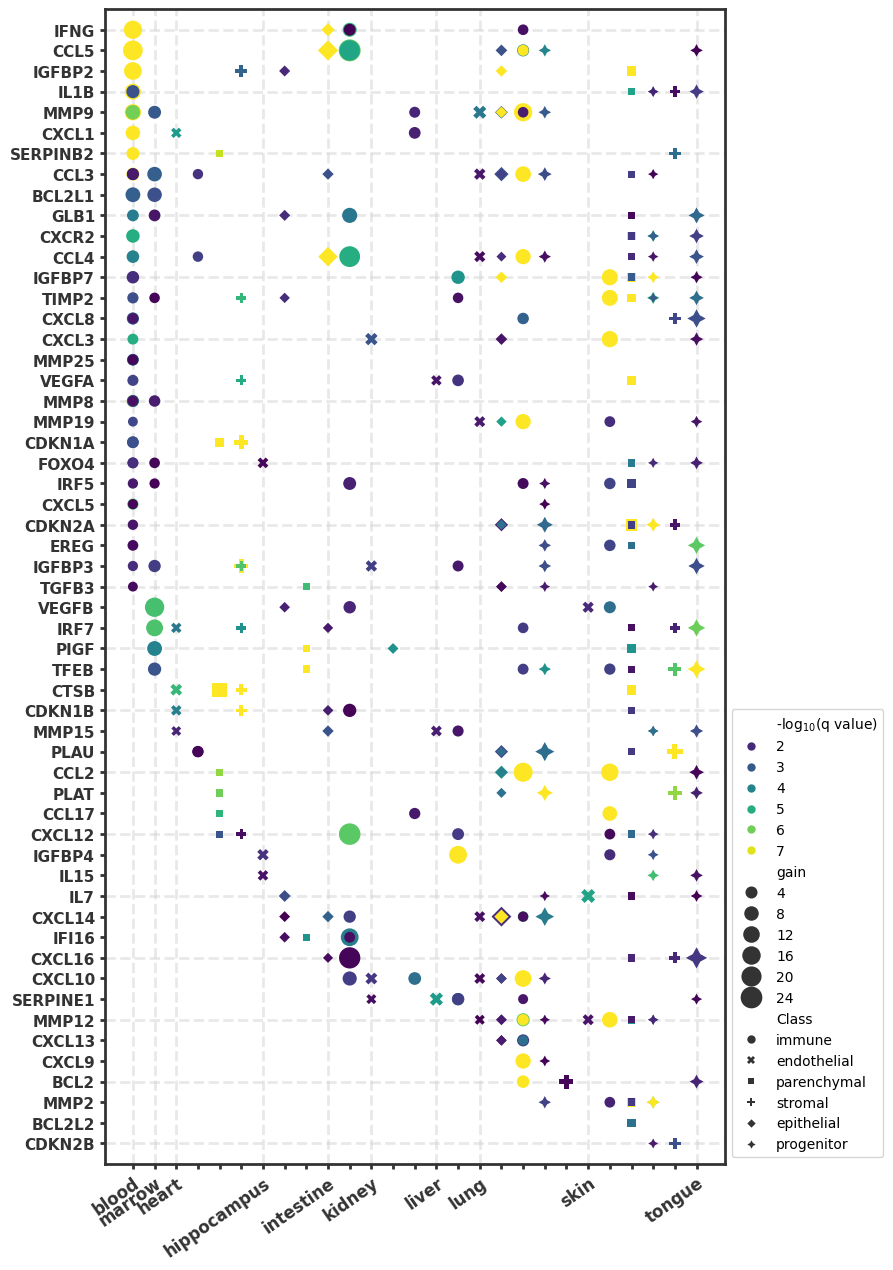

In [27]:
plt.figure(figsize = (8,15))

_ = scatter_df[scatter_df.BH < 0.05]

ax = sns.scatterplot(data = _, x = 'X', y = 'gene', size = 'gain', hue = 'nlogq',
                    sizes=(50, 250), palette = 'viridis',
                     style = 'Class', linewidth=0)


ax.set(ylim=(len(_.gene.unique()), -1))


for x, y in enumerate(_.gene.unique()):
    if x%3 == 0:
        ax.axhline(y=y, xmin=0, xmax=1, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
        

prev = 0
for x in _[['tissue', 'Class']].drop_duplicates().groupby('tissue').count().values:
    ax.axvline(x=prev, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
    prev += x[0]   

        
plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 11, weight = 'bold', color = '0.2')

plt.xlabel('')
plt.ylabel('')
ax.tick_params(width = 2, color = '0.2')

for axis in ['bottom', 'left', 'right', 'top']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('0.2')

    
# Customize the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [r'-log$_{10}$(q value)' if 'nlogq' in label else label for label in labels]
ax.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, .4))


#####MAKE SURE TO CHANGE THIS IF THE GRAPH CHANGES ############
mod_labs = ['blood', 'marrow', 'heart', '', '', '', 'hippocampus', '', '', 'intestine', '', 'kidney', '', '',
            'liver', '', 'lung', '', '', '', '', 'skin', '', '', '', '', 'tongue']
plt.xticks(ticks = plt.gca().get_xticks(),
           labels=mod_labs)
#################



plt.savefig('figures/R1_1F_pt1.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_1F_pt1.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [25]:
_.reset_index(drop = True).to_csv('sup_tables/human_marker_map.csv')

In [50]:
# a_thing_to_get_correct_order = []

# for x in scatter_df.gene.unique().tolist():
#     if x not in scatter_df[scatter_df.tissue == 'blood'].gene.values:
#         a_thing_to_get_correct_order.append(['blood', 'nothing', 'immune', x, np.nan, np.nan, np.nan, np.nan, 'blood_immune'])
        
# a_thing_to_get_correct_order = pd.DataFrame(a_thing_to_get_correct_order, columns = scatter_df.columns)


# scatter_df = pd.concat((scatter_df, a_thing_to_get_correct_order))
# scatter_df = scatter_df.sort_values(['gene', 'tissue'])

### Fig 1F - depricated

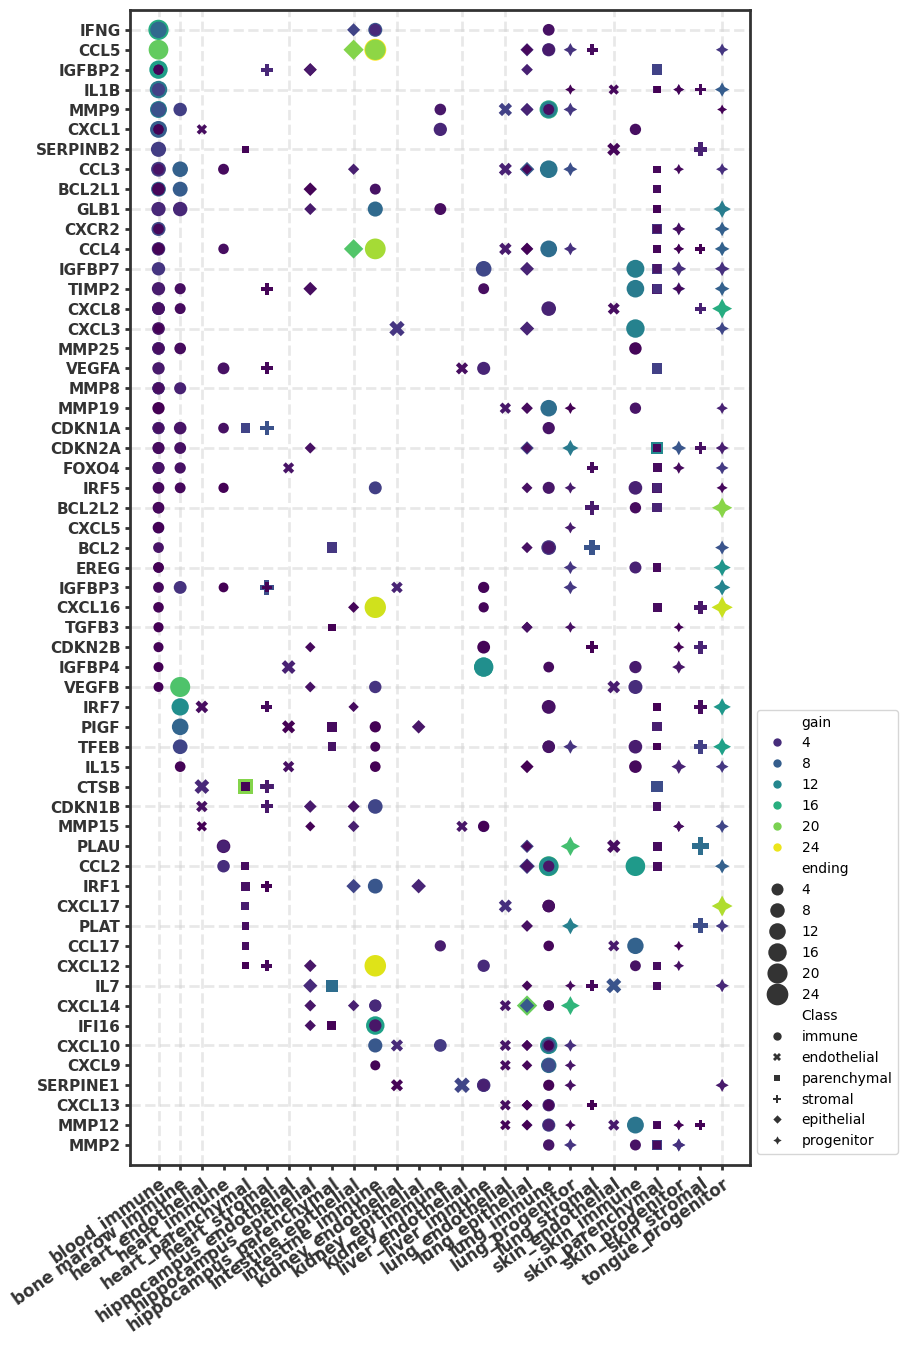

In [67]:
plt.figure(figsize = (8,15))

ax = sns.scatterplot(data = scatter_df, x = 'X', y = 'gene', size = 'ending', hue = 'gain',
                    sizes=(50, 250), palette = 'viridis',
                     style = 'Class', linewidth=0) #, markers = [], style_order =


ax.set(ylim=(len(scatter_df.gene.unique()), -1))


for x, y in enumerate(scatter_df.gene.unique()):
    if x%3 == 0:
        ax.axhline(y=y, xmin=0, xmax=1, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
        

prev = 0
for x in scatter_df[['tissue', 'Class']].drop_duplicates().groupby('tissue').count().values:
    ax.axvline(x=prev, ls = '--', c='lightgrey', zorder = 0, alpha = 0.5, lw = 2)
    prev += x[0]   

        
plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 11, weight = 'bold', color = '0.2')

plt.xlabel('')
plt.ylabel('')
ax.tick_params(width = 2, color = '0.2')

for axis in ['bottom', 'left', 'right', 'top']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('0.2')

    
ax.legend(bbox_to_anchor=(1, .4))

#plt.savefig('for_poster/tissue_sen_het_human.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('figures/1F_pt1.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/1F_pt1.svg', bbox_inches = 'tight')


plt.show()  

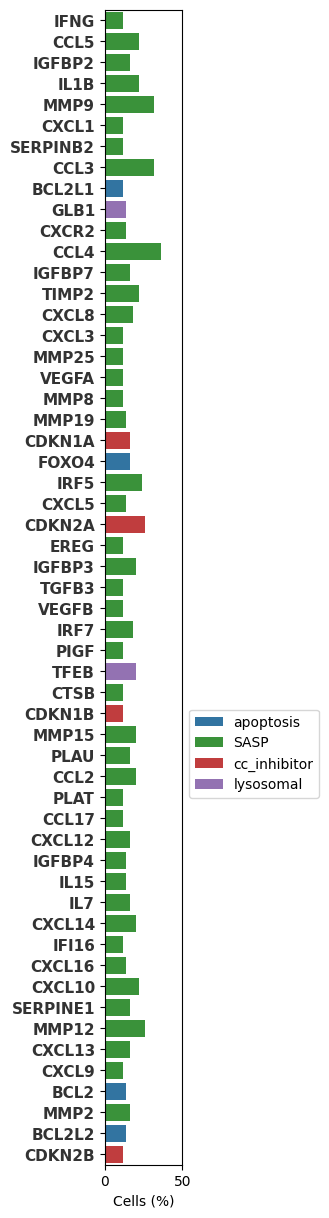

In [28]:
clean_markers = {x:v.split(' ')[0] for (x,v) in markers.items()}

bar_df = _[['gene', 'cell_count']].drop_duplicates() #.gene.unique().tolist()


bar_df['Cells (%)'] = bar_df.cell_count/len(tc_df_filt.drop_duplicates(['tissue', 'cell_type_2']))*100


bar_df['gene_type'] = bar_df.gene.map(clean_markers)

#temp_color = {'apoptosis':'tab:blue', 'SASP':'tab:green', 'cc_inhibitor':'tab:red', 'lysosomal':'tab:purple'}
#bar_df['colors'] = bar_df.gene_type.map(temp_color)


plt.figure(figsize = (1,15))

ax = sns.barplot(data = bar_df, x = 'Cells (%)', y = 'gene', hue = 'gene_type',dodge=False,
                hue_order = ['apoptosis', 'SASP', 'cc_inhibitor', 'lysosomal'],
                palette = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple'])

ax.legend(bbox_to_anchor=(1, .4))


plt.yticks(size = 11, weight = 'bold', color = '0.2')
plt.ylabel('')

plt.xlim(right = 50)

#plt.savefig('for_poster/tissue_sen_het_human_bar.png', dpi = 300, bbox_inches = 'tight')
plt.savefig('figures/R1_1F_pt2.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.savefig('figures/R1_1F_pt2.svg', bbox_inches = 'tight', transparent = True)

plt.show()

In [62]:
bar_df.sort_values('cell_count')

age_bin,gene,cell_count,Cells (%),gene_type
251,CXCL3,6,12.0,SASP
1097,CTSB,6,12.0,SASP
1029,IRF1,6,12.0,SASP
998,CXCL17,6,12.0,SASP
1056,PLAT,6,12.0,SASP
841,PIGF,6,12.0,SASP
533,VEGFB,6,12.0,SASP
746,VEGFA,6,12.0,SASP
242,CXCL1,6,12.0,SASP
2253,IFI16,6,12.0,SASP


In [63]:
len(tc_df_filt.drop_duplicates(['tissue', 'cell_type_2'])) #tot number of cell pops tested

50

### Sup Fig 3C part 3/4

In [2]:
adata = sc.read_h5ad('for_poster/human_all_highly_var_SCVI.h5ad')
bdata = sc.read_h5ad('/home/jrlab/Downloads/HUMAN_CELLS_COMBINED_wHIPPO.h5ad')

In [3]:
def get_cells_expressing_set(adata, genes, threshold):
    data = adata[:, genes].X.toarray()
    data[data > 0] = 1
    return data.sum(axis = 1) >= threshold

def another_fun_y(x):
    age, thing = x
    if age < 50 and thing == 1:
        return 'young pos'
    return 'neg'

def another_fun_o(x):
    age, thing = x
    if age >= 50 and thing == 1:
        return 'old pos'
    return 'neg'

### Fig 1D

In [16]:
sc.set_figure_params(dpi_save = 600)

In [14]:
cell_type_2_annotations = pd.read_csv('../data/annotations/human/cell_classes.csv')

class_d = dict(zip(cell_type_2_annotations.cell_type_2, cell_type_2_annotations['class']))

adata.obs['Class'] = adata.obs.cell_type_2.map(class_d)
adata = adata[~adata.obs.Class.isin(['doublets', 'erythroid-like', 'unknown'])]
adata.obs['Class'] = adata.obs['Class'].replace({'germ line': 'progenitor'})

/tmp/ipykernel_2188943/1362197129.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Class'] = adata.obs['Class'].replace({'germ line': 'progenitor'})


/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


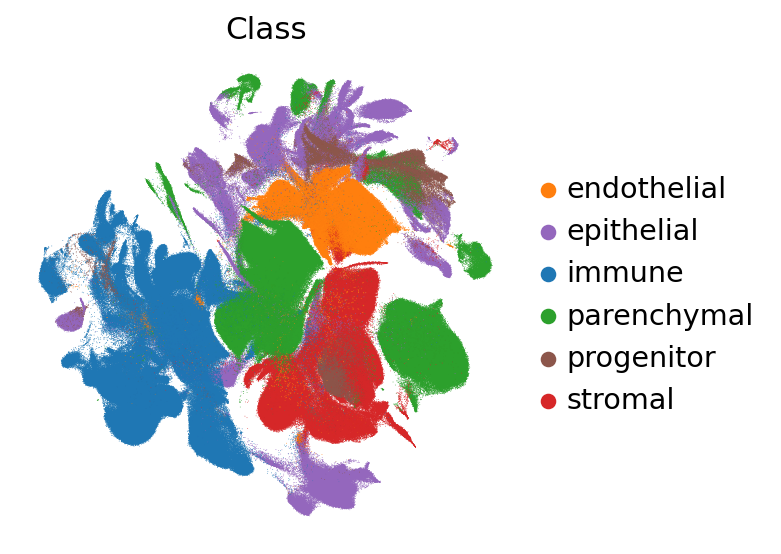

In [18]:
with rc_context({'figure.figsize': (4,4)}):
    ax = sc.pl.umap(adata, frameon = False, s = .5, color = 'Class',
                    palette = ['tab:orange', 'tab:purple', 'tab:blue', 'tab:green', 'tab:brown',  'tab:red'],
                   save = '_1D_pt2.svg')

In [4]:
#CDKN2A
adata.obs['thing'] = get_cells_expressing_set(bdata,
                    ['CDKN2A'], 1)*1 #ratio_df index because these were filtered for dynamic
adata.obs['thing_young'] = adata.obs[['age', 'thing']].apply(another_fun_y, axis = 1)
adata.obs['thing_old'] = adata.obs[['age', 'thing']].apply(another_fun_o, axis = 1)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


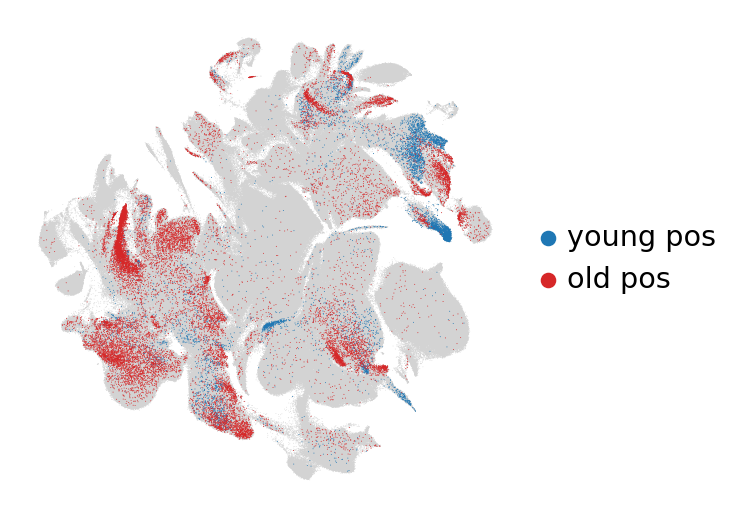

In [10]:
with rc_context({'figure.figsize': (4,4)}):
    ax = sc.pl.umap(adata, frameon = False, palette = ['whitesmoke'], s = .5,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs.thing_young != 'neg'], color = 'thing_young', s = .75, palette = ['tab:blue'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs.thing_old != 'neg'], color = 'thing_old', s = .75, palette = ['tab:red'],
               ax = ax, title = '', save = '_1D_pt1.svg')
    #save = 'hum_p16_pos_all.png

/tmp/ipykernel_2188943/1606736665.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


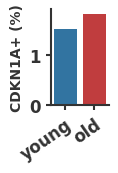

In [7]:
temp_val1 = len(adata.obs[adata.obs.thing_young == 'young pos'])\
    /len(adata.obs[adata.obs.age < 50])*100

temp_val2 = len(adata.obs[adata.obs.thing_old == 'old pos'])\
    /len(adata.obs[adata.obs.age >= 50])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('CDKN1A+ (%)', size = 10, weight = 'bold', color = '0.2')

#plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/_1D_pt3.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/_1D_pt3.svg', bbox_inches = 'tight')


plt.show()

In [18]:
sc.set_figure_params(dpi_save = 600)

### Sup Fig 3C pt 3

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


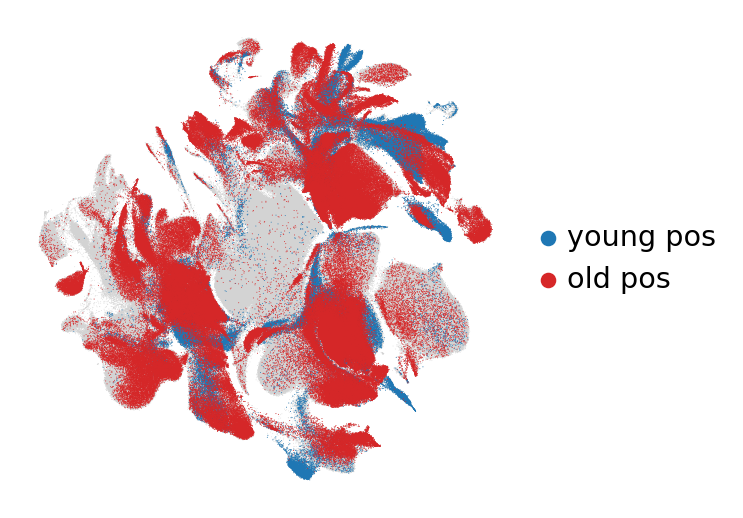

In [20]:
#CDKN1A
adata.obs['thing'] = get_cells_expressing_set(bdata,
                    ['CDKN1A'], 1)*1 #ratio_df index because these were filtered for dynamic
adata.obs['thing_young'] = adata.obs[['age', 'thing']].apply(another_fun_y, axis = 1)
adata.obs['thing_old'] = adata.obs[['age', 'thing']].apply(another_fun_o, axis = 1)

with rc_context({'figure.figsize': (4,4)}):
    ax = sc.pl.umap(adata, frameon = False, palette = ['whitesmoke'], s = .5,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs.thing_young != 'neg'], color = 'thing_young', s = .75, palette = ['tab:blue'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs.thing_old != 'neg'], color = 'thing_old', s = .75, palette = ['tab:red'],
               ax = ax, title = '', save = '_S3C_pt3.png')
    #save = 'hum_p16_pos_all.png

In [21]:
import matplotlib as mpl
mpl.rcdefaults()

/tmp/ipykernel_2017636/2795458832.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


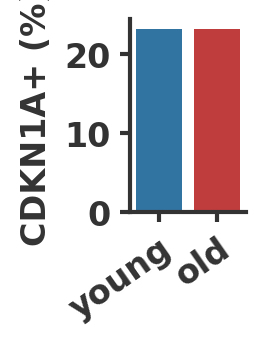

In [22]:
temp_val1 = len(adata.obs[adata.obs.thing_young == 'young pos'])\
    /len(adata.obs[adata.obs.age < 50])*100

temp_val2 = len(adata.obs[adata.obs.thing_old == 'old pos'])\
    /len(adata.obs[adata.obs.age >= 50])*100

plt.figure(figsize = (0.75, 1.25))
ax = sns.barplot(x = ['young', 'old'], y = [temp_val1,temp_val2], palette = ['tab:blue', 'tab:red'])


for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('0.2')
ax.tick_params(width = 1.5, color = '0.2')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(size = 12, rotation = 35, rotation_mode = 'anchor', ha = 'right', weight = 'bold', color = '0.2')
plt.yticks(size = 12, weight = 'bold', color = '0.2')

plt.ylabel('CDKN1A+ (%)', size = 12, weight = 'bold', color = '0.2')

#plt.ylim(top = 2)

ax.grid(False)

plt.savefig('figures/S3C_pt4.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S3C_pt4.svg', bbox_inches = 'tight')


plt.show()

# Skin example - Sup Fig 3B

In [49]:
import scvi

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
adata = sc.read_h5ad('/home/jrlab/Downloads/HUMAN_CELLS_MS0203.h5ad')

In [51]:
with open('../data/annotations/human/skin_index_dictionary.pickle', 'rb') as handle:
     fin_skin_d = pickle.load(handle)

In [52]:
adata.obs['cell_type'] = adata.obs.index.map(fin_skin_d)

In [53]:
adata = adata[adata.obs.study == 'skin']

In [54]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata



sc.pp.highly_variable_genes(adata, flavor = 'seurat_v3', n_top_genes=6000,
                            layer = "counts", subset = True)

scvi.model.SCVI.setup_anndata(adata, layer = 'counts', categorical_covariate_keys=['donor'])
vae = scvi.model.SCVI(adata)
vae.train()

/tmp/ipykernel_2017636/2605604030.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' 

Epoch 196/196: 100%|█| 196/196 [09:14<00:00,  2.83s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=196` reached.


Epoch 196/196: 100%|█| 196/196 [09:14<00:00,  2.83s/it, v_num=1, train_loss_step


In [55]:
adata.obsm['X_scVI'] = vae.get_latent_representation()
#adata.layers['scvi_normalized'] = vae.get_normalized_expression(library_size = 1e4)

sc.pp.neighbors(adata,  use_rep = 'X_scVI')
sc.tl.leiden(adata, resolution=0.15)
sc.tl.umap(adata)

In [56]:
sc.set_figure_params(dpi_save = 600)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


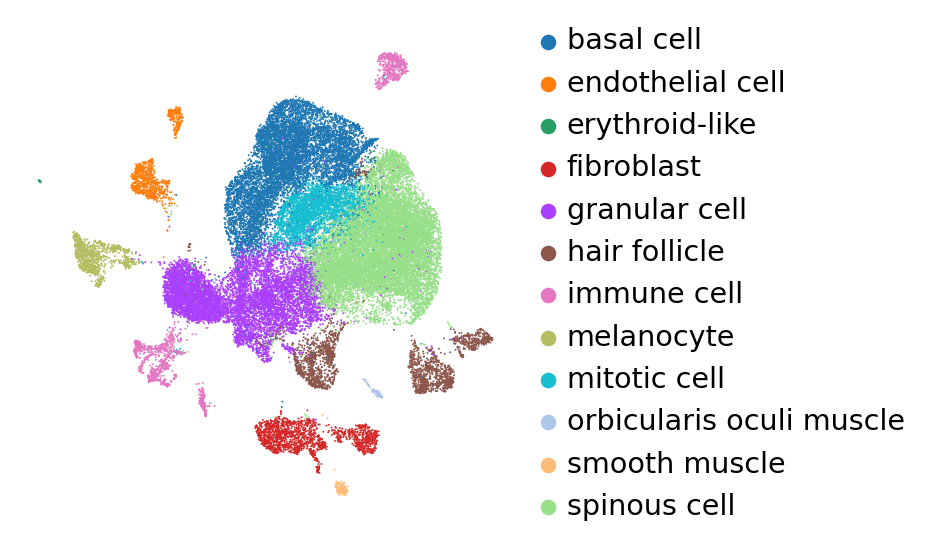

In [59]:
with rc_context({'figure.figsize': (4,4)}):
    sc.pl.umap(adata, color = 'cell_type', title = '', frameon=False, save = '_S3B_pt1.svg')

In [60]:
adata.obs.age.unique()

array([18., 22., 23., 44., 47., 48.])

In [61]:
def get_cells_expressing_set(adata, genes, threshold):
    data = adata[:, genes].X.toarray()
    data[data > 0] = 1
    return data.sum(axis = 1) >= threshold

def another_fun_y(x):
    age, thing = x
    if age < 40 and thing == 1:
        return 'young pos'
    return 'neg'

def another_fun_o(x):
    age, thing = x
    if age >= 40 and thing == 1:
        return 'old pos'
    return 'neg'

In [62]:
#CDKN2A
adata.obs['thing'] = get_cells_expressing_set(adata,['CDKN2A'], 1)*1 #ratio_df index because these were filtered for dynamic
adata.obs['thing_young'] = adata.obs[['age', 'thing']].apply(another_fun_y, axis = 1)
adata.obs['thing_old'] = adata.obs[['age', 'thing']].apply(another_fun_o, axis = 1)

/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jrlab/miniconda3/envs/senepy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data f

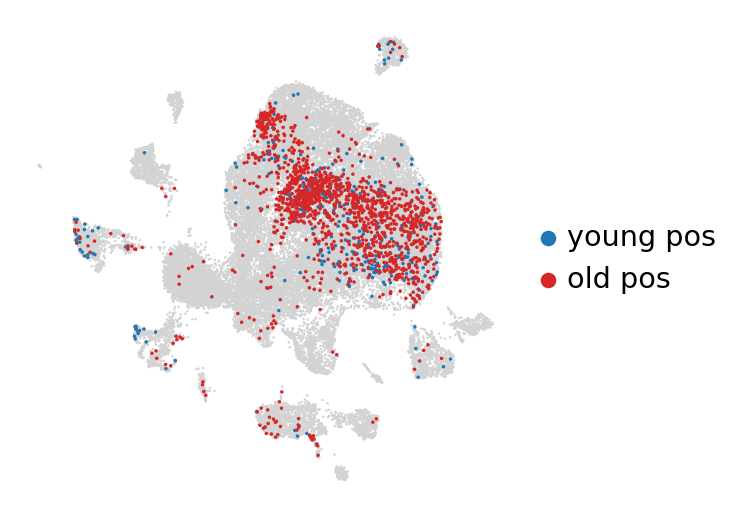

In [66]:
with rc_context({'figure.figsize': (4,4)}):
    ax = sc.pl.umap(adata, frameon = False, palette = ['whitesmoke'], s = 5,
                    legend_loc = None, show = False)


    sc.pl.umap(adata[adata.obs.thing_young != 'neg'], color = 'thing_young', s = 10, palette = ['tab:blue'],
               ax = ax, title = '', show = False)
    
    sc.pl.umap(adata[adata.obs.thing_old != 'neg'], color = 'thing_old', s = 10, palette = ['tab:red'],
               ax = ax, title = '',  save = '_S3B_pt2.png')
    #save = 'hum_p16_pos_all.png

In [67]:
temp = adata.obs.groupby(['age']).count()
c_d = dict(zip(temp.index, temp.tissue))

In [68]:
df = adata.obs.groupby(['age', 'thing']).count().reset_index()[['age', 'thing', 'tissue']]
df['total'] = df.age.map(c_d)
df = df[df.thing == 1]
df['per'] = df.tissue/df.total * 100
df['Age'] = ['young']*3 + ['old']*3
df

,age,thing,tissue,total,per,Age
1,18.0,1,202,11985,1.685440,young
3,22.0,1,61,3126,1.951376,young
5,23.0,1,97,7081,1.369863,young
7,44.0,1,442,7034,6.283765,old
9,47.0,1,472,5640,8.368794,old
11,48.0,1,550,5974,9.206562,old


In [70]:
mpl.rcdefaults()

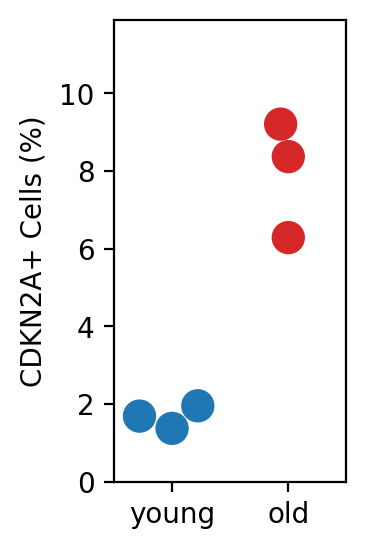

In [84]:
plt.figure(figsize = (1.5,3))

#ax = sns.boxplot(data = df, x = 'Age', y = 'per', color = 'w')
ax = sns.swarmplot(data = df, x = 'Age', y = 'per', hue = 'Age', palette=['tab:blue', 'tab:red'], size = 12)

plt.ylim(bottom = 0)

plt.xlabel('')
plt.ylabel('CDKN2A+ Cells (%)')

plt.ylim(top = 11.9) #room for sig bar

plt.savefig('figures/S3B_pt3.png', dpi = 600, bbox_inches = 'tight')
plt.savefig('figures/S3B_pt3.svg', bbox_inches = 'tight')

plt.show()

In [83]:
stats.ttest_ind(df[df.Age == 'young'].per, df[df.Age == 'old'].per)

TtestResult(statistic=-7.100136119231102, pvalue=0.002078396179149842, df=4.0)